In [1]:
BIT_WIDTH = 8
EPOCHS = 1
Q_EPOCHS = 1
BATCH_SIZE = 256
MODEL_NAME = 'model'

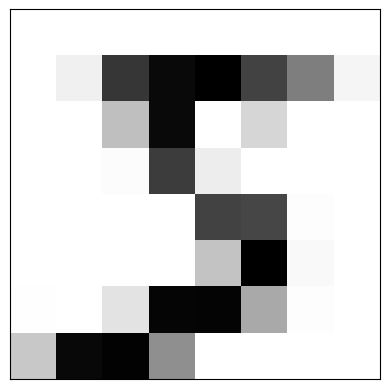

In [2]:
import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8

# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
data_zoom = mnist.MNISTData(size_initial=20, size_final=8, color_depth=8, flat=True)
# todo: 
data_zoom.x_train = data_zoom.x_train*(2**(BIT_WIDTH))
data_zoom.x_test = data_zoom.x_test*(2**(BIT_WIDTH))

# x_train= data_zoom.x_train
# y_train= data_zoom.y_train
# x_test= data_zoom.x_test
# y_test= data_zoom.y_test

ax = plt.subplot(1, 1 , 1)
plt.imshow(data_zoom.x_train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# def model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from callbacks import all_callbacks
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow_model_optimization as tfmot
import os 
# import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8
# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=8, flat=True)

class QAutoencoder:
    def __init__(self, data: mnist.MNISTData, bit_width=8, EPOCHS=1, Q_EPOCHS=1, model_name='model'):
        self.x_train = data.x_train
        self.y_train = data.y_train
        self.x_test = data.x_test
        self.y_test = data.y_test
        self.input_min = np.min(data.x_train)
        self.input_max = np.max(data.x_train)
        self.input_shape = (data.x_train.shape[-1],)
        self.BIT_WIDTH = bit_width
        self.EPOCHS = EPOCHS
        self.Q_EPOCHS = Q_EPOCHS
        self.MODEL_NAME = model_name
        self.model = self.autoencoder_model_gen()
        self.history = None
        self.loss = None
        self.float_model_predictions = None
        self.path_to_model =    None

        self.path_to_quantized_model = f'model/QAE_model{self.BIT_WIDTH}bits_mini/KERAS_check_best_model_mini.model'
        self.q_aware_model = None
        self.quantized_tflite_model = None
        self.interpreter = None
        self.input_details = None
        self.output_details = None
        self.quantized_model_predictions = None

    def autoencoder_model_gen(self):

        # Encoder
        # encoder_input = Input(shape=self.input_shape)
        # encoder_l1 = Dense(64, activation='relu')(encoder_input)
        # encoder_l2 = Dense(32, activation='relu')(encoder_l1)
        # encoder_l3 = Dense(16, activation='relu')(encoder_l2)
        # encoder_output = Dense(2, activation='relu')(encoder_l3)
        
        # # Decoder
        # decoder_l1 = Dense(16, activation='relu')(encoder_output)
        # decoder_l2 = Dense(32, activation='relu')(decoder_l1)
        # decoder_l3 = Dense(32, activation='relu')(decoder_l2)
        
        encoder_input = Input(shape=self.input_shape)
        decoder_output = Dense(self.x_train.shape[-1], activation='linear')(encoder_input)


        # # Encoder
        # encoder_input = Input(shape=self.input_shape)
        # encoder_l1 = Dense(64, activation='relu')(encoder_input)
        # # encoder_l2 = Dense(50, activation='relu')(encoder_l1)
        # # encoder_l3 = Dense(32, activation='relu')(encoder_l2)
        # # encoder_l4 = Dense(16, activation='relu')(encoder_l3)
        # # encoder_l5 = Dense(8, activation='relu')(encoder_l4)
        # encoder_l6 = Dense(4, activation='relu')(encoder_l1)
        # encoder_output = Dense(2, activation='relu')(encoder_l6)

        # # Decoder
        # decoder_l1 = Dense(16, activation='relu')(encoder_output)
        # # decoder_l2 = Dense(32, activation='relu')(decoder_l1)
        # # decoder_l3 = Dense(32, activation='relu')(decoder_l2)
        # # decoder_output = Dense(y_train.shape[-1], activation='sigmoid')(decoder_l3) # classifier
        # # decoder_output = Dense(
        # #     self.x_train.shape[-1], activation='sigmoid')(decoder_l3)  # autoencoder
        # # decoder_output = Dense(self.x_train.shape[-1], activation='linear')(decoder_l3)
        # decoder_output = Dense(self.x_train.shape[-1], activation='linear')(decoder_l1)


        # Model
        model = Model(inputs=encoder_input, outputs=decoder_output)
        # refactor the code above to use the functional AP

        model.compile(optimizer='adam', loss='mse')
        # model.compile(optimizer='adam', loss='binary_crossentropy') # classifier
        return model

    def fit_data(self, batch_size=256, epochs=Q_EPOCHS):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""

        callbacks = all_callbacks(stop_patience=1000,
                                  lr_factor=0.5,
                                  lr_patience=10,
                                  lr_epsilon=0.000001,
                                  # min_delta=0.000001,
                                  lr_cooldown=2,
                                  lr_minimum=0.0000001,
                                #   outputDir=f'model/QAE_model{self.BIT_WIDTH}bits/callbacks')
        # callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
                                outputDir=f'model/callbacks_mini')

        self.history = self.model.fit(self.x_train, self.x_train,
                                      validation_data=(
                                          self.x_test, self.x_test),
                                      batch_size=batch_size, epochs=epochs,
                                      shuffle=True, callbacks=callbacks.callbacks)
        # self.model = strip_pruning(self.model)
        self.loss = self.model.evaluate(self.x_test, self.x_test, verbose=0)
        path_to_model =    f'model/model_{self.loss}loss/KERAS_check_best_model_mini.model'
        self.model.save(
            # f'model/QAE_model{self.BIT_WIDTH}bits/KERAS_check_best_model.h5')
           path_to_model)
        self.history = self.history.history
        self.convert_to_Q_aware()

    def plot_float_model(self, n=6):
        """Plot the float model"""
        
        plt.figure(figsize=(10, 3))
        self.float_model_predictions = self.model.predict(self.x_test)
        self.plot_model_predictions(
            n,
            self.float_model_predictions,
            './images/float_model/reconstructed images {model_name}_mini.png',
        )

    def representative_dataset(self):
        for data in self.x_train:
            # Scale the data using min and max values
            scaled_data = (data - self.input_min) / (self.input_max - self.input_min) * (2 ** (self.BIT_WIDTH - 1))
            yield [np.array([scaled_data], dtype=np.float32)]

    def convert_to_Q_aware(self):

        # converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # converter.representative_dataset = self.representative_dataset
        # converter.target_spec.supported_ops = [
        #     tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        # converter.inference_input_type = tf.int8
        # converter.inference_output_type = tf.int8

        # self.q_aware_model = converter.convert()

        # # Load the quantized model
        # self.interpreter = tf.lite.Interpreter(
        #     model_path='quantized_model.tflite')
        # self.interpreter.allocate_tensors()
        # ------------
        quantize_model = tfmot.quantization.keras.quantize_model
        self.q_aware_model = quantize_model(self.model)
        self.q_aware_model.compile(optimizer='adam', loss='mse')
        self.fit_data_Q_aware()
        # loss = self.q_aware_model.evaluate(self.x_test, self.x_test, verbose=0)

        # # Save the quantized model
        # with open(f'quantized_model.tflite', 'wb') as f:
        #     f.write(self.q_aware_model)

        self.convert_to_tflite()

    def fit_data_Q_aware(self, batch_size=256, epochs=Q_EPOCHS):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""

        callbacks = all_callbacks(stop_patience=1000,
                                  lr_factor=0.5,
                                  lr_patience=10,
                                  lr_epsilon=0.000001,
                                  # min_delta=0.000001,
                                  lr_cooldown=2,
                                  lr_minimum=0.0000001,
                                  outputDir=f'model/QAE_model{self.BIT_WIDTH}bits_mini/callbacks')
        # callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())

        self.history_Q_aware = self.q_aware_model.fit(self.x_train, self.x_train,
                                      validation_data=(
                                          self.x_test, self.x_test),
                                      batch_size=batch_size, epochs=epochs,
                                      shuffle=True, callbacks=callbacks.callbacks)
        # self.model = strip_pruning(self.model)
        
        self.q_aware_model.save(
            # f'model/QAE_model{self.BIT_WIDTH}bits/KERAS_check_best_model.h5')
            self.path_to_quantized_model)
        self.history_Q_aware = self.history_Q_aware.history
        self.loss = self.q_aware_model.evaluate(self.x_test, self.x_test, verbose=0)
        # self.convert_to_Q_aware()    

    def convert_to_tflite(self):
        converter = tf.lite.TFLiteConverter.from_keras_model(self.q_aware_model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = self.representative_dataset
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8

        self.quantized_tflite_model = converter.convert()

        # Save the TensorFlow Lite model
        with open("model_obj_tflite_model_mini.tflite", "wb") as file:
            file.write(self.quantized_tflite_model)

        # Load the quantized model
        # self.interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
        self.interpreter = tf.lite.Interpreter(model_content=self.quantized_tflite_model)

        self.interpreter.allocate_tensors()

        # Get input and output details
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.quantized_predictions()

    def quantized_predictions(self, n=50):
        quantized_model_predictions = []

        for i in range(n):
            # Prepare input data
            # input_data = np.array(
            #     [self.x_test[i]*(2**(self.BIT_WIDTH-1))], dtype=np.int8)
            # input_data = np.array([(self.x_test[i] - self.input_min) / (self.input_max - self.input_min) * (2 ** (self.BIT_WIDTH - 1))], dtype=np.int8)  
            input_data = np.array([(self.x_test[i] - self.input_min) / (self.input_max - self.input_min) * (2 ** (self.BIT_WIDTH))], dtype=np.int8)  

            self.interpreter.set_tensor(
                self.input_details[0]['index'], input_data)
            # print(f"input_data: {input_data}")

            # Run inference
            self.interpreter.invoke()

            # Get output
            output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
            output_data = self.interpreter.get_tensor(
                # self.output_details[0]['index']) / (2 ** (self.BIT_WIDTH - 1))
                self.output_details[0]['index'])
            # output_data = output_data * (self.input_max - self.input_min) / (2 ** (self.BIT_WIDTH - 1)) + self.input_min
            # output_data = output_data / (2 ** (self.BIT_WIDTH - 1))
            quantized_model_predictions.append(output_data)
            # print(f"output_data: {output_data}")
        
        self.quantized_model_predictions = quantized_model_predictions
        # self.compute_mse()

    def plot_quantized_model(self, n=6):
        
        plt.figure(figsize=(10, 3))
        self.plot_model_predictions(
            n,
            self.quantized_model_predictions,
            './images/QAE/reconstructed images{model_name}_mini.png',
        )

    def plot_model_predictions(self, n, quantized_model_predictions, imgs_path):
        img_size = int(np.sqrt(self.input_shape[0]))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            self.plot_imgs(
                self.x_test, i, img_size, ax
            )
            ax = plt.subplot(2, n, i + n + 1)
            self.plot_imgs(
                quantized_model_predictions, i, img_size, ax
            )
        if not os.path.exists(imgs_path):
            os.makedirs(imgs_path)
        plt.savefig(imgs_path.format(model_name=" complete"))
        plt.show()

    def plot_imgs(self, arg0, i, img_size, ax):
        plt.imshow(arg0[i].reshape(img_size, img_size), cmap='gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    def compute_mse(self):
        mse = mean_squared_error(self.float_model_predictions, self.quantized_model_predictions)
        print(f'Mean Squared Error between floating point and quantized model predictions: {mse}')
        self.mse = mse

model_obj = QAutoencoder(data_zoom, bit_width=BIT_WIDTH, model_name=MODEL_NAME, EPOCHS=EPOCHS, Q_EPOCHS=Q_EPOCHS)
# model.fit(x_train, y_train, epochs=10, batch_size=32) # classifier
model_obj.model.summary()
# model.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE) #autoencoder


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
Total params: 4,160
Trainable params: 4,160
Non-trainable params: 0
_________________________________________________________________


# fit

In [4]:
model_obj.fit_data(epochs=EPOCHS)  # batch_size=BATCH_SIZE, epochs=EPOCHS)


228/235 [============================>.] - ETA: 0s - loss: 7802.3677
***callbacks***
saving losses to model/callbacks_mini\losses.log

Epoch 00001: val_loss improved from inf to 3900.66602, saving model to model/callbacks_mini\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/callbacks_mini\KERAS_check_best_model.model\assets

Epoch 00001: val_loss improved from inf to 3900.66602, saving model to model/callbacks_mini\KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model/callbacks_mini\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/callbacks_mini\KERAS_check_model_last.model\assets

Epoch 00001: saving model to model/callbacks_mini\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 2s 8ms/step - loss: 7698.2793 - val_loss: 3900.6660 - lr: 0.0010
INFO:tensorflow:Assets written to: model/model_3900.666015625loss/KERAS_check_best_model_mini.model\assets
225/235 [======================

INFO:tensorflow:Assets written to: model/QAE_model8bits_mini/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits_mini/callbacks\KERAS_check_best_model.model\assets



Epoch 00001: val_loss improved from inf to 4746.37646, saving model to model/QAE_model8bits_mini/callbacks\KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model/QAE_model8bits_mini/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits_mini/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits_mini/callbacks\KERAS_check_model_last.model\assets



Epoch 00001: saving model to model/QAE_model8bits_mini/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 15ms/step - loss: 7345.4736 - val_loss: 4746.3765 - lr: 0.0010


INFO:tensorflow:Assets written to: model/QAE_model8bits_mini/KERAS_check_best_model_mini.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits_mini/KERAS_check_best_model_mini.model\assets


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmpdkg3l1ws\assets


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmpdkg3l1ws\assets


# Save objects

In [5]:
model_obj.loss

4746.3759765625

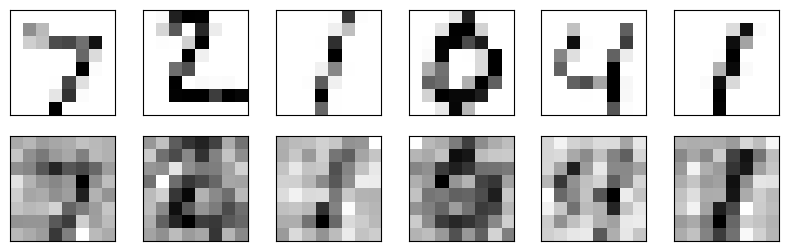

In [6]:
model_obj.plot_float_model()

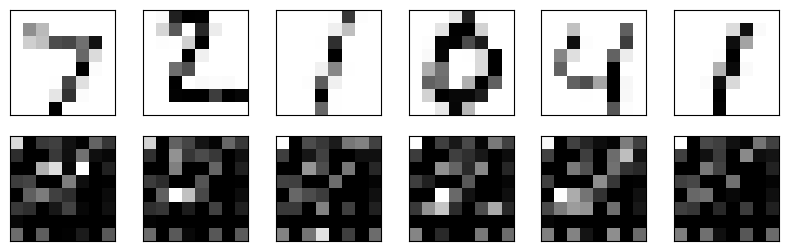

In [7]:
# obj = model_obj
# plot_quantized_model(obj, n=6)
model_obj.plot_quantized_model(n=6)

## saving as pickle

In [8]:
import os

MODEL_DIR = os.path.abspath("model/model_obj_tf_model")
# ASSETS_DIR = os.path.join(MODEL_DIR, "assets")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# if not os.path.exists(ASSETS_DIR):
#     os.makedirs(ASSETS_DIR)
MODEL_DIR

'c:\\Users\\luisa\\OneDrive\\Documentos\\GitHub\\Autoencoder-for-FPGA\\Qaware\\model_obj_tf_model'

In [9]:
os.path.join(MODEL_DIR, "tf_model")

'c:\\Users\\luisa\\OneDrive\\Documentos\\GitHub\\Autoencoder-for-FPGA\\Qaware\\model_obj_tf_model\\tf_model'

In [ ]:
import pickle
MINI = True

if MINI:
    mini = "_mini"
else:
    mini = ""

def save_objects(model_obj):
    # Save the Keras model
    model_obj.model.save(f'model/model_obj_keras_model{mini}.h5')

    # Save the .tflite model
    with open(f"model/model_obj_tflite_model{mini}.tflite", "wb") as file:
        file.write(model_obj.quantized_tflite_model)

    # Save other attributes
    attrs_to_save = {
        'x_train': model_obj.x_train,
        # 'y_train': model_obj.y_train,
        'x_test': model_obj.x_test,
        'y_test': model_obj.y_test,
        'input_shape': model_obj.input_shape,
        'BIT_WIDTH': model_obj.BIT_WIDTH,
        'EPOCHS': model_obj.EPOCHS,
        'Q_EPOCHS': model_obj.Q_EPOCHS,
        'MODEL_NAME': model_obj.MODEL_NAME,
        'history': model_obj.history,
        'loss': model_obj.loss,
        'float_model_predictions': model_obj.float_model_predictions,
        'quantized_model_predictions': model_obj.quantized_model_predictions,
        'input_min': model_obj.input_min,
        'input_max': model_obj.input_max,
        'path_to_model': model_obj.path_to_model,
        'path_to_quantized_model': model_obj.path_to_quantized_model
        # 'history_Q_aware': model_obj.history_Q_aware,
        # 'mse': model_obj.mse,
    }
    with open(f'model/model_obj_attributes{mini}.pickle', 'wb') as f:
        pickle.dump(attrs_to_save, f)





In [11]:
# Save the objects of model_obj
save_objects(model_obj)

In [ ]:
import pickle

def load_objects():
    
    # model_obj.model.save('model_obj_keras_model.h5')
    # Load the TensorFlow model
    loaded_model = tf.keras.models.load_model(os.path.join(MODEL_DIR, "tf_model"))

    # Load the Keras model
    loaded_keras_model = tf.keras.models.load_model('model/model_obj_keras_model.h5')

    # Load the .tflite model
    with open("model/model_obj_tflite_model.tflite", "rb") as file:
        loaded_tflite_model = file.read()

    # Load other attributes
    with open('model/model_obj_attributes.pickle', 'rb') as f:
        loaded_attributes = pickle.load(f)
    
    # Create a new QAutoencoder object and set the attributes
    loaded_model_obj = QAutoencoder(data_zoom, bit_width=loaded_attributes['BIT_WIDTH'], model_name=loaded_attributes['MODEL_NAME'],
                                    EPOCHS=loaded_attributes['EPOCHS'], Q_EPOCHS=loaded_attributes['Q_EPOCHS'])
    
    loaded_model_obj.model = loaded_keras_model
    loaded_model_obj.quantized_tflite_model = loaded_tflite_model
    loaded_model_obj.input_shape = loaded_attributes['input_shape']
    loaded_model_obj.x_train = loaded_attributes['x_train']
    # loaded_model_obj.y_train = loaded_attributes['y_train']
    loaded_model_obj.x_test = loaded_attributes['x_test']
    loaded_model_obj.y_test = loaded_attributes['y_test']
    loaded_model_obj.model = loaded_model
    loaded_model_obj.history = loaded_attributes['history']
    loaded_model_obj.loss = loaded_attributes['loss']
    loaded_model_obj.float_model_predictions = loaded_attributes['float_model_predictions']
    loaded_model_obj.quantized_model_predictions = loaded_attributes['quantized_model_predictions']
    loaded_model_obj.interpreter = loaded_tflite_model
    loaded_model_obj.input_min = loaded_attributes['input_min']
    loaded_model_obj.input_max = loaded_attributes['input_max']
    loaded_model_obj.path_to_model = loaded_attributes['path_to_model']
    loaded_model_obj.path_to_quantized_model = loaded_attributes['path_to_quantized_model']
    # loaded_model_obj.mse = loaded_attributes['mse']



    # Recreate the TFLite interpreter
    loaded_model_obj.interpreter = tf.lite.Interpreter(model_content=loaded_tflite_model)
    loaded_model_obj.interpreter.allocate_tensors()
    loaded_model_obj.input_details = loaded_model_obj.interpreter.get_input_details()
    loaded_model_obj.output_details = loaded_model_obj.interpreter.get_output_details()
    # loaded_model_obj.convert_to_Q_aware()

    return loaded_model_obj

In [ ]:
# Load the objects and create a new model_obj
loaded_model_obj = load_objects()

In [ ]:
loaded_model_obj.x_train.shape

(60000, 64)

In [ ]:
loaded_model_obj.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
 dense_4 (Dense)             (None, 16)                48        
                                                                 
 dense_5 (Dense)             (None, 32)                544   

In [ ]:
# loaded_model_obj.quantized_tflite_model

# Clone and fine-tune pre-trained model with quantization aware training


In [ ]:
model_obj.model

In [ ]:
# import tensorflow_model_optimization as tfmot
# model = model_obj.model
# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(model)

# # `quantize_model` requires a recompile.
# # q_aware_model.compile(optimizer='adam',
# #               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# #               metrics=['accuracy'])
# q_aware_model.compile(optimizer='adam', loss='mse')

# q_aware_model.summary()

### Train and evaluate the model against baseline

To demonstrate fine tuning after training the model for just an epoch, fine tune with quantization aware training on a subset of the training data.

In [ ]:
model_obj.x_train[0:1000]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.94140625, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00390625, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# train_images_subset = model_obj.x_train[0:1000] # out of 60000
# train_labels_subset = model_obj.x_train[0:1000]

# q_aware_model.fit(train_images_subset, train_labels_subset,
#                   batch_size=500, epochs=1)

In [ ]:
# baseline_model_accuracy = model_obj.model.evaluate(
#     model_obj.x_test, model_obj.x_test, verbose=0)

# q_aware_model_accuracy = model_obj.q_aware_model.evaluate(
#    model_obj.x_test, model_obj.x_test, verbose=0)

# print('Baseline test accuracy:', baseline_model_accuracy)
# print('Quant test accuracy:', q_aware_model_accuracy)

## Create quantized model for TFLite backend

After this, you have an actually quantized model with int8 weights and uint8 activations.

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model_obj.q_aware_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# q_aware_model = converter.convert()

## See persistence of accuracy from TF to TFLite

Define a helper function to evaluate the TF Lite model on the test dataset.

In [ ]:
import numpy as np

def evaluate_model(interpreter, x_test, n=6):
#   input_index = interpreter.get_input_details()[0]["index"]
#   output_index = interpreter.get_output_details()[0]["index"]
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

#   # Run predictions on every image in the "test" dataset.
#   prediction_digits = []
#   for i, test_image in enumerate(test_images):
#     if i % 1000 == 0:
#       print('Evaluated on {n} results so far.'.format(n=i))
#     # Pre-processing: add batch dimension and convert to float32 to match with
#     # the model's input data format.
#     test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
#     interpreter.set_tensor(input_index, test_image)

#     # Run inference.
#     interpreter.invoke()

#     # Post-processing: remove batch dimension and find the digit with highest
#     # probability.
#     output = interpreter.tensor(output_index)
#     digit = np.argmax(output()[0])
#     prediction_digits.append(digit)

#   print('\n')
#   # Compare prediction results with ground truth labels to calculate accuracy.
#   prediction_digits = np.array(prediction_digits)
#   accuracy = (prediction_digits == test_labels).mean()
#   return accuracy

    quantized_model_predictions = []

    for i in range(n):
        # Prepare input data
        # input_data = np.array(
        #     [x_test[i]*(2**(BIT_WIDTH-1))], dtype=np.int8)
        # input_data = np.array([(x_test[i] - input_min) / (input_max - input_min) * (2 ** (BIT_WIDTH - 1))], dtype=np.int8)  
        input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)


        interpreter.set_tensor(
            input_details[0]['index'], input_data)
        # print(f"input_data: {input_data}")
        # Run inference
        interpreter.invoke()

        # Get output
        output_data = interpreter.get_tensor(output_details[0]['index'])
        # output_data = interpreter.get_tensor(
        #     output_details[0]['index']) / (2 ** (BIT_WIDTH - 1))
        # output_data = output_data * (input_max - input_min) / (2 ** (BIT_WIDTH - 1)) + input_min
        # output_data = output_data / (2 ** (BIT_WIDTH - 1))
        # print(f"output_data: {output_data}")
        quantized_model_predictions.append(output_data)
    accuracy = (input_data == quantized_model_predictions).mean()
    
    # quantized_model_predictions = quantized_model_predictions
    return accuracy

You evaluate the quantized model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [ ]:
# interpreter = tf.lite.Interpreter(model_content=q_aware_model)
# interpreter.allocate_tensors()

# # test_accuracy = evaluate_model(interpreter, test_images=model_obj.x_test, test_labels=model_obj.x_test)
# test_accuracy = evaluate_model(interpreter, model_obj.x_test, n=6)

# print('Quant TF test accuracy:', q_aware_model_accuracy)
# print('Quant TFLite test_accuracy:', test_accuracy)

In [ ]:
model_obj.q_aware_model.layers

In [ ]:
for layer in model_obj.q_aware_model.layers:
  if hasattr(layer, 'quantize_config'):
    for weight, quantizer, quantizer_vars in layer._weight_vars:
        quantized_and_dequantized = quantizer(weight, training=False, weights=quantizer_vars)
        min_var = quantizer_vars['min_var']
        max_var = quantizer_vars['max_var']
        print(quantized_and_dequantized*(2**(BIT_WIDTH)))
        # quantized = dequantize(quantized_and_dequantized, min_var, max_var, quantizer)

tf.Tensor(
[[-12.541695  -39.018612   48.773262  ... -12.541695   20.20607
   60.618202 ]
 [ -9.754654  -13.238457    3.4838028 ...  13.238457  -49.470028
   45.98623  ]
 [ -2.0902786 -18.812546  -46.682983  ...  27.870438  -58.52792
   -4.877327 ]
 ...
 [ -7.6643677 -58.52792   -50.86355   ... -26.476913   48.0765
   49.470024 ]
 [ -6.270851    6.967613   35.534813  ... -25.083393  -36.231567
  -41.805656 ]
 [-50.86355    22.296349   59.92144   ... -24.386635  -41.805656
   49.470024 ]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[ 34.464035  -55.272507  -42.26721   -28.611649 ]
 [ 57.873573   31.862976   51.37092   -13.005295 ]
 [ 24.710068   30.562447   -7.1529083 -48.11959  ]
 [-72.82965    56.573036   -5.202118   68.27781  ]
 [ -4.5518494  29.261917  -70.22859   -22.759266 ]
 [ 13.655563   34.464035  -39.66615    16.90689  ]
 [ 68.27781    -4.5518494 -68.2778     18.857681 ]
 [ 11.054504  -46.81906   -32.513237   47.469337 ]
 [ 30.562447   57.873573   40.966682  -73.47992  ]
 [-26

In [ ]:
model_obj.quantized_tflite_model.layers

AttributeError: 'bytes' object has no attribute 'layers'

In [ ]:
model_obj.interpreter.layers

In [ ]:
model_obj.plot_float_model()

In [ ]:
# obj = model_obj
# plot_quantized_model(obj, n=6)
model_obj.plot_quantized_model(n=6)

## See 4x smaller model from quantization

You create a float TFLite model and then see that the quantized TFLite model
is 4x smaller.

In [ ]:
import tempfile
import os

In [ ]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model_obj.model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(model_obj.quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

In [ ]:
float_converter.get_tensor_details()